In [246]:
from src.statespace import RWModel, CVModel, CAModel, StateSpace
from src.trajectory import Trajectory
from src.kalmanfilter import KalmanFilter
from src.utils import rmse

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

sns.set()

In [247]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
ndat = 100
q = 1e-3
r = 1
c_rwm = 10  # RWM Process Noise Multiplicative constant
init_state = np.zeros(6)

cam = CAModel(q, r)
traj = Trajectory(cam, ndat, init_state)

In [249]:
traj.X[-1]

array([9.37454674e+02, 1.12355393e+02, 1.92891326e+01, 1.37935823e+00,
       4.42286424e-01, 3.58596153e-02])

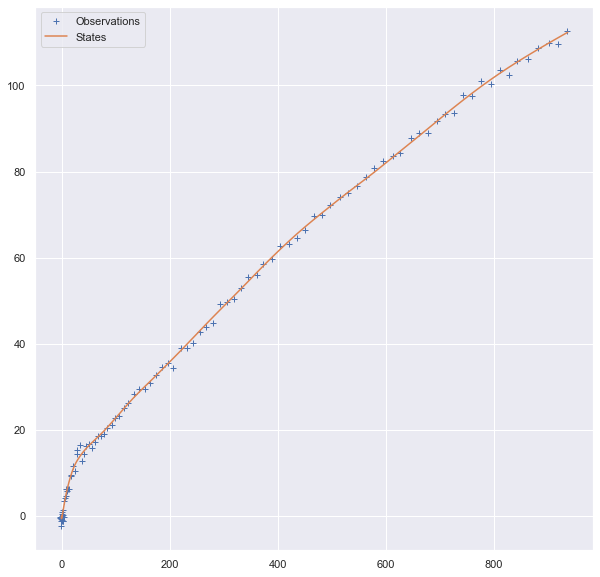

In [250]:
# Plot trajectory
plt.figure(figsize=(10, 10))
# plt.axis("equal")
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.legend()
plt.show()

In [251]:
rwm = RWModel(c_rwm*q, r)
cvm = CVModel(q, r)

kf_rwm = KalmanFilter(rwm)
kf_rwm_coop = KalmanFilter(rwm)
kf_cvm = KalmanFilter(cvm)
kf_cam = KalmanFilter(cam)

kf_rwm_coop.add_nbhs(kf_cvm, kf_cam)
kf_cvm.add_nbhs(kf_rwm, kf_cam)
kf_cam.add_nbhs(kf_rwm, kf_cvm)

In [252]:
for yt in traj.observations:
    kf_rwm.predict()
    kf_rwm_coop.predict()
    kf_cvm.predict()
    kf_cam.predict()
    
    kf_rwm.update(yt, log=True)
    kf_rwm_coop.update(yt)
    kf_cvm.update(yt)
    kf_cam.update(yt, log=True)
    
    kf_rwm_coop.get_nbh_estimates()
    kf_cvm.get_nbh_estimates()
#     kf_cam.get_nbh_estimates()
    
    kf_rwm_coop.cov_intersect(log=True)
    kf_cvm.cov_intersect(log=True)
#     kf_cam.cov_intersect()
    
hist_rwm = kf_rwm.history
hist_rwm_coop = kf_rwm_coop.history
hist_cvm = kf_cvm.history
hist_cam = kf_cam.history

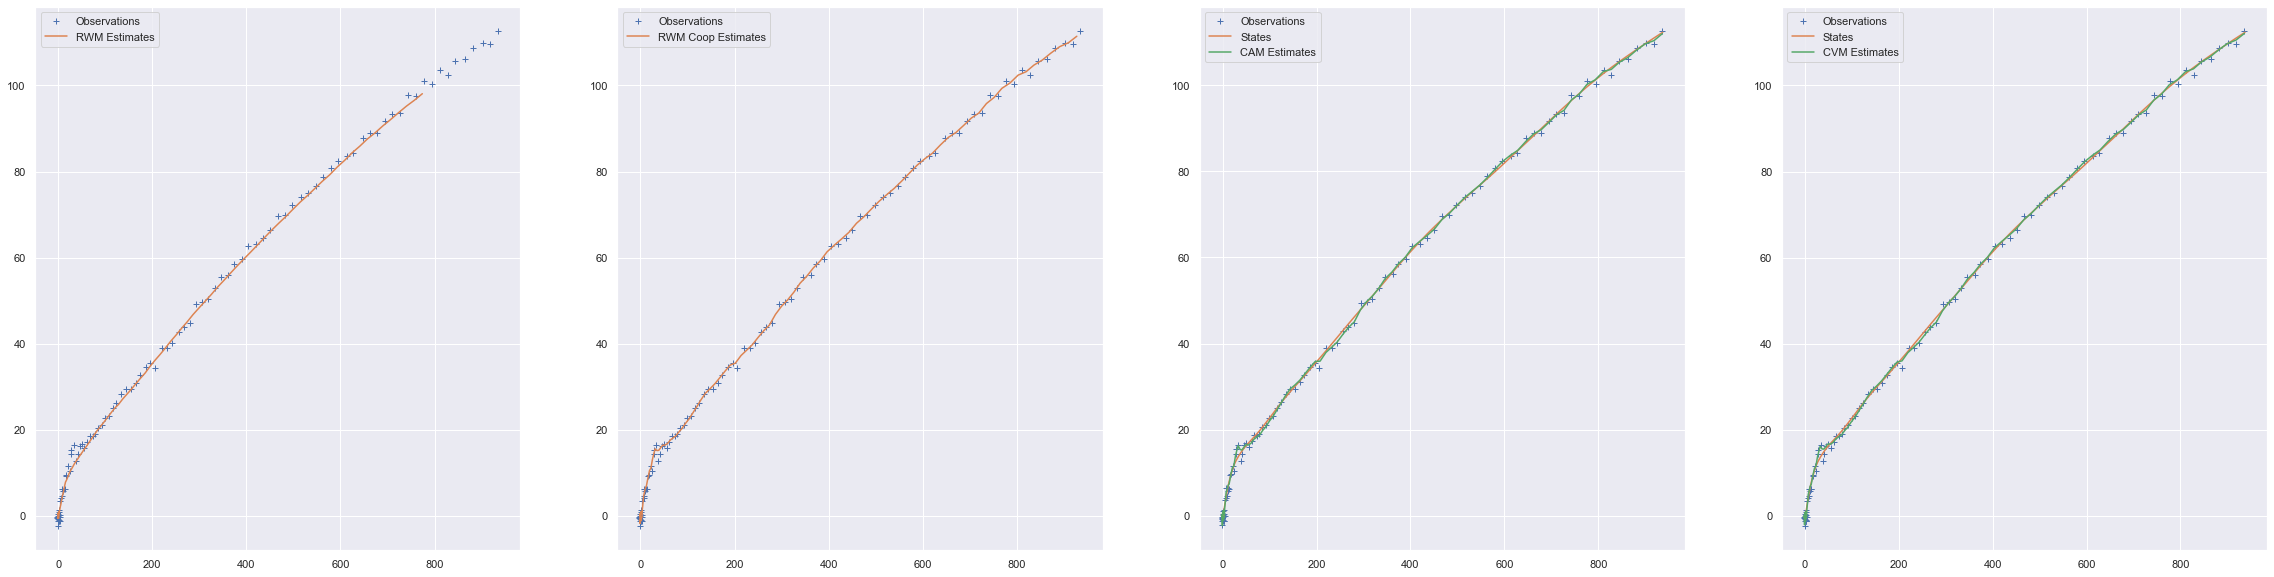

In [253]:
plt.figure(figsize=(40, 10))

plt.subplot(1, 4, 1)
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
# plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.plot(hist_rwm[:, 0], hist_rwm[:, 1], label="RWM Estimates")
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
# plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.plot(hist_rwm_coop[:, 0], hist_rwm_coop[:, 1], label="RWM Coop Estimates")
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.plot(hist_cam[:, 0], hist_cam[:, 1], label="CAM Estimates")
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(traj.Y[:, 0], traj.Y[:, 1], "+", label="Observations")
plt.plot(traj.X[:, 0], traj.X[:, 1], label="States")
plt.plot(hist_cvm[:, 0], hist_cvm[:, 1], label="CVM Estimates")
plt.legend()

plt.show()

In [254]:
rmse_rwm = rmse(traj.X[:, :2], hist_rwm[:, :2], ndat)
rmse_rwm_coop = rmse(traj.X[:, :2], hist_rwm_coop[:, :2], ndat)
rmse_cvm = rmse(traj.X[:, :2], hist_cvm[:, :2], ndat)
rmse_cam = rmse(traj.X[:, :2], hist_cam[:, :2], ndat)

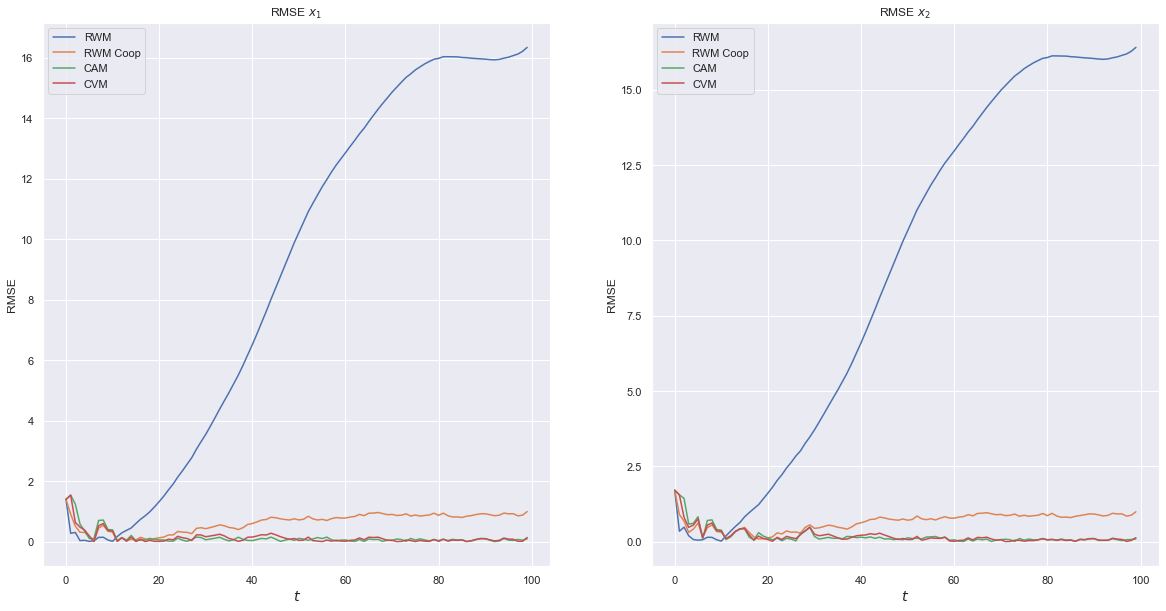

In [255]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("RMSE $x_1$ ")
plt.plot(rmse_rwm[:, 0], label="RWM")
plt.plot(rmse_rwm_coop[:, 0], label="RWM Coop")
plt.plot(rmse_cam[:, 0], label="CAM")
plt.plot(rmse_cvm[:, 0], label="CVM")
plt.xlabel("$t$", fontsize="large")
plt.ylabel("RMSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("RMSE $x_2$ ")
plt.plot(rmse_rwm[:, 1], label="RWM")
plt.plot(rmse_rwm_coop[:, 1], label="RWM Coop")
plt.plot(rmse_cam[:, 1], label="CAM")
plt.plot(rmse_cvm[:, 1], label="CVM")
plt.xlabel("$t$", fontsize="large")
plt.ylabel("RMSE")
plt.legend()

plt.show()